# REAL OPTIONS VALUATION
## Least-squares Monte Carlo method, multiple stochastic factors

One advantage of the least-squares Monte Carlo method is that it can value options that depend on multiple factors. Now, we will relax the assumption that soybeans prices are the only source of uncertainty in our project and we will also consider soybean meal prices and soybean oil prices as additional stochastic factors.

In [1]:
import os
from time import sleep
from warnings import filterwarnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from tqdm import tqdm
import statsmodels.formula.api as smf

import xlwings as xw

from rpy2.robjects import pandas2ri

filterwarnings('ignore')
pandas2ri.activate()


In [2]:
figure = {'figsize': (16, 6),
          'facecolor': '#f9f9f9',
          'subplot.wspace': 0.1,
          'dpi': 120}

colors = ["#ab5787",
          "#51b2e5",
          "#703c5c",
          "#168dd9",
          "#d190b6",
          "#00609f",
          "#d365ba",
          "#154866",
          "#666666",
          "#c4c4c4"]

axes = {'grid': True,
        'spines.left': False,
        'spines.right': False,
        'spines.top': False,
        'spines.bottom': False,
        'grid.axis': 'y',
        'facecolor': '#f9f9f9',
        'edgecolor': '#f9f9f9',
        'autolimit_mode': 'round_numbers',
        'xmargin': 0,
        'prop_cycle': cycler('color', colors)}

grid = {'color': '#979797', 'linewidth': 0.2}

tick = {'color': '#979797', 'major.size': 0, 'minor.size': 0}

plt.rc('figure', **figure)
plt.rc('axes', **axes)
plt.rc('grid', **grid)
plt.rc(('xtick', 'ytick'), **tick)


In [17]:
link1 = 'https://www.indexmundi.com/commodities/?commodity=soybeans&months=360'
link2 = 'https://www.indexmundi.com/commodities/?commodity=soybean-meal&months=360'
link3 = 'https://www.indexmundi.com/commodities/?commodity=soybean-oil&months=360'

links = [link1, link2, link3]

names = ['soybean', 'soymeal', 'soyoil']

df = pd.DataFrame()
for link, name in zip(links, names):
    if not os.path.exists('{}_prices.csv'.format(name)):
        df_temp = (pd.read_html(link,
                   attrs={'class': 'tblData'},
                   header=0, parse_dates=['Month'])[0]
                   .drop('Change', axis=1)
                   .to_csv('{}_prices.csv'.format(name)))

    df_temp = (pd.read_csv('{}_prices.csv'.format(name), parse_dates=['Month'])
               .drop(columns={'Unnamed: 0'})
               .rename(str.lower, axis='columns')
               .rename(columns={'price': '{}_prices'.format(name)})
               .set_index('month'))

    df = pd.concat((df, df_temp), axis=1)

    sleep(1)

In [18]:
df.head()

,soybean_prices,soymeal_prices,soyoil_prices
month,,,
1989-05-01,297.0,256.0,460.0
1989-06-01,291.0,256.0,464.0
1989-07-01,272.0,256.0,447.0
1989-08-01,236.0,214.0,404.0
1989-09-01,237.0,216.0,410.0


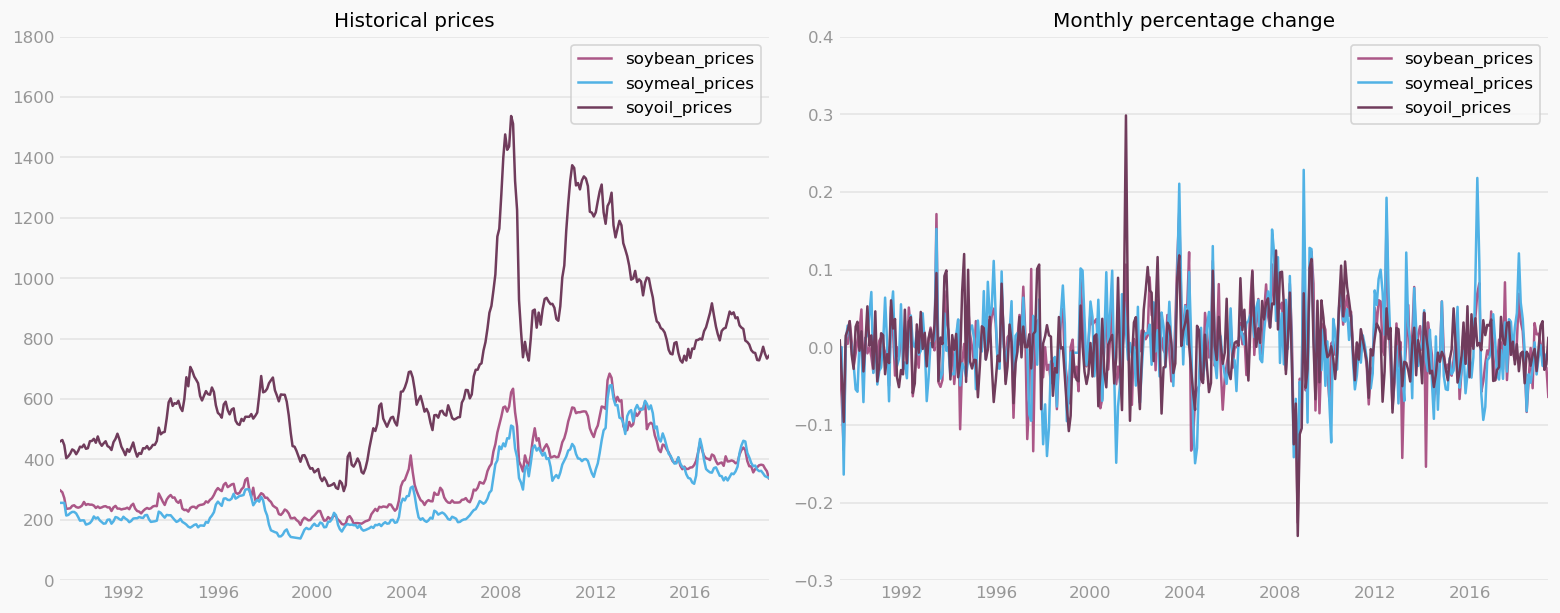

In [5]:
plt.subplot(121)
plt.plot(df)
plt.legend(df.columns)
plt.title('Historical prices')

plt.subplot(122)
plt.plot(df.pct_change().dropna())
plt.legend(df.columns)
plt.title('Monthly percentage change');

It’s pretty obvious that all three of our stochastic factors are correlated, therefore we will employ the correlated geometric Brownian motion, which can be represented by the following system of stochastic differential equations:

$$\begin{pmatrix}
\mathrm{d}S_{1,t}\\
\mathrm{d}S_{2,t}\\
\mathrm{d}S_{3,t}\\
\end{pmatrix} = 
\begin{pmatrix}
\mu_1 S_{1,t}\\
\mu_2 S_{2,t}\\
\mu_3 S_{3,t}\\
\end{pmatrix}\mathrm{d}t+
\begin{pmatrix}
\sigma_1 S_{1,t}& 0 & 0\\
0 &\sigma_2 S_{2,t} &0\\
0&0&\sigma_3 S_{3,t}\\
\end{pmatrix}
\begin{pmatrix}
\mathrm{d}W_{1, t}\\
\mathrm{d}W_{2, t}\\
\mathrm{d}W_{3, t}\\
\end{pmatrix}$$

The Wiener processes $W_{i,t}$ are correlated. To estimate the model, we need to transform them into the independent Wiener processes. This can be most easily done via the Cholesky decomposition. Indeed, if Y is a multivariate Gaussian random variable with variance–covariance matrix $\Sigma$, then $\Sigma = A {A}^\top$, and $AZ\sim N(0, \Sigma)$, where $Z\sim N(0, I)$. 

Now, fitting and simulating this system in <code>YUIMA</code> is a piece of cake. We still assume that the drift is zero in each equation.

In [8]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [10]:
%%R -i df -o coefs
require('yuima')
set.seed(0)

df <- cbind(df$soybean_prices, df$soymeal_prices, df$soyoil_prices)

mat <- matrix(rep(1:3, 3), 3, 3)
diffusion <- matrix(paste("c", mat, t(mat),'*x', mat, sep=""), 3, 3)
diffusion[lower.tri(diffusion, diag=FALSE)] <- 0

mult_gbm <- setModel(drift=c(0, 0, 0),
                     diffusion=diffusion, state.var=c("x1", "x2", "x3"))

model <- setYuima(data=setData(df, delta=1/12), model=mult_gbm)

start <- list(
              c11=0.001, c12=0.001, c22=0.001,
              c13=0.001, c23=0.001, c33=0.001)

lower <- list(
              c11=0.001, c12=0.001, c22=0.001,
              c13=0.001, c23=0.001, c33=0.001)

upper <- list(
              c11=1, c12=1, c22=1,
              c13=1, c23=1, c33=1)

fit <- qmle(model, start=start, upper=upper, lower=lower)

result <- data.frame(summary(fit)@coef)

coefs <- data.frame(rownames(result), result)


In [11]:
coefs


,rownames.result.,Estimate,Std..Error
0,c11,0.109517,0.004062
1,c12,0.089221,0.006660
2,c13,0.100687,0.008336
3,c22,0.185390,0.006895
4,c23,0.067743,0.010092
5,c33,0.170226,0.006329


In [12]:
%%R -o sim
set.seed(0)
X = simulate(mult_gbm, true.parameter=fit@fullcoef, delta=1/12, xinit=list(df[nrow(df),]))
sim = data.frame('soybeans_prices'=get.zoo.data(X)[[1]],
                 'soymeal_prices'=get.zoo.data(X)[[2]],
                 'soyoil_prices'=get.zoo.data(X)[[3]])
sim = sim[-1,]

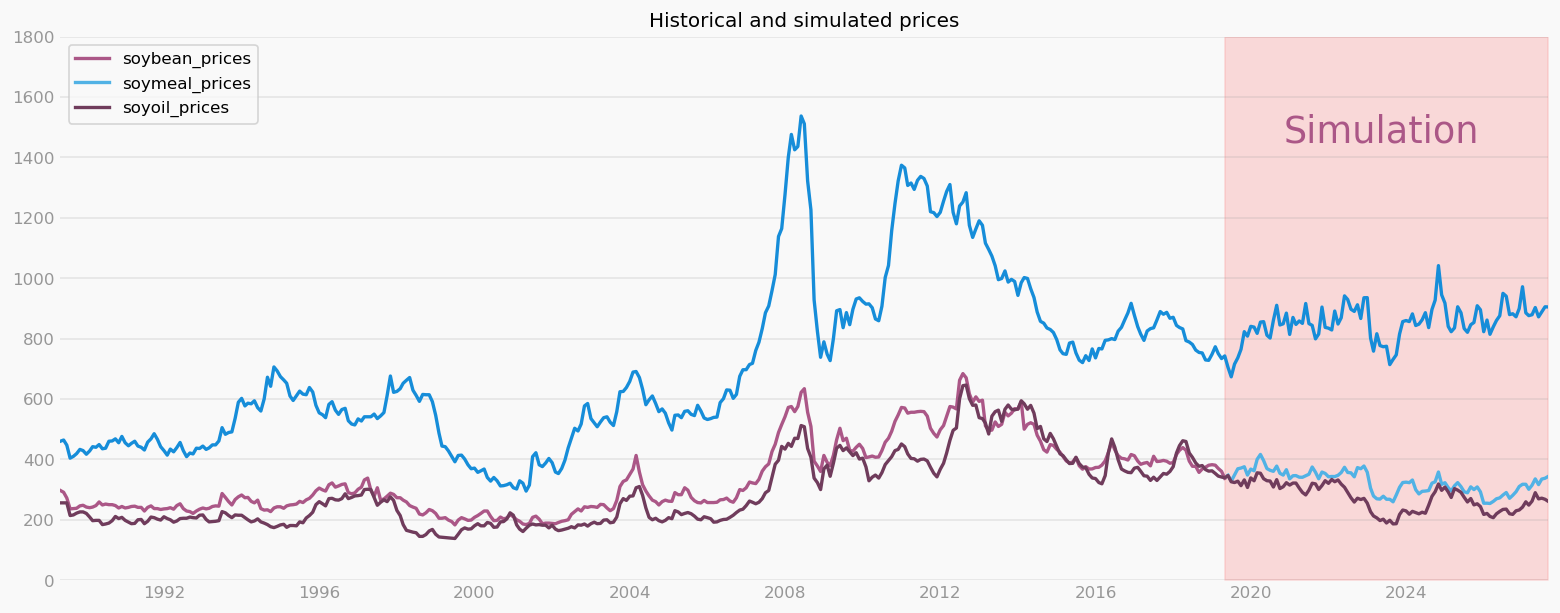

In [13]:
ind_last = df.index[-1]

start = pd.Timestamp(ind_last)
end = pd.Timestamp(start+pd.DateOffset(months=100))

dt_index = pd.DatetimeIndex(freq='MS',
                            start=ind_last+pd.DateOffset(months=1),
                            periods=100)
df_plus_simulation = df.append(sim.set_index(dt_index))

fig, ax = plt.subplots()
ax.plot(df_plus_simulation, linewidth=2)

ylim = ax.get_ylim()
ax.fill_between([start, end], *ylim, color='#f9a8a8', alpha=.4)
ax.set_ylim(*ylim)

ax.annotate("Simulation", (start+pd.DateOffset(months=18),  1450),
            fontsize=22, color='#ab5787')
ax.legend(df.columns, loc='upper left')
ax.set_title('Historical and simulated prices');


In [14]:
%%R
set.seed(seed=NULL)

coef = fit@coef

simulate_mgbm <- function (time=9) {
    samp <- setSampling(Initial=1, delta=1, n=time)
    
    X <- simulate(mult_gbm, sampling=samp, true.parameter=coef,
                  xinit=df[length(df[,1]),])
  
    return(as.list(data.frame(get.zoo.data(X))))}

In [15]:
n_sims = 1000

wb = xw.Book('ROV_model_3.xlsx')

sht_inputs = wb.sheets['Inputs']
dr, t = sht_inputs.range('assum').value
t = int(t)
sht_inputs.range('date').value = df.index[-1]
sht_inputs.range('prices').value = df.iloc[-1, :].values.reshape(3, 1)

soybeans_prices = np.zeros((n_sims, t-1))
soymeal_prices = np.zeros((n_sims, t-1))
soyoil_prices = np.zeros((n_sims, t-1))
S = np.zeros((n_sims, t))

sht = wb.sheets['Calculations_s']
K = np.array(sht.range('strike').value)

temp = sht.range('sim_inp').value

for i in tqdm(range(n_sims)):
    X = %R -i t simulate_mgbm(time=t-1)
    soybeans_prices[i] = np.array(X[0])[1:]
    soymeal_prices[i] = np.array(X[1])[1:]
    soyoil_prices[i] = np.array(X[2])[1:]

for i in tqdm(range(n_sims)):
    sim_out = np.vstack((soybeans_prices[i],
                         soymeal_prices[i],
                         soyoil_prices[i]))
    sht.range('sim_inp').value = sim_out
    S[i] = sht.range('sim_out').value

sht.range('sim_inp').value = temp


100%|██████████| 1000/1000 [00:53<00:00, 18.31it/s]


In [16]:
CF = np.zeros((n_sims, t))
V = np.maximum(K - S, 0)
dif_f = 1 / (1 + dr)
CF[:, -1] = V[:, -1]
for tp in range(t-2, 0, -1):
    ind = V[:, tp] > 0
    X1 = soybeans_prices[ind, tp]
    X2 = soymeal_prices[ind, tp]
    X3 = soyoil_prices[ind, tp]
    Y = CF[ind, tp + 1] * dif_f
    dat = {'Y': Y, 'X1': X1, 'X2': X2, 'X3': X3}
    reg = smf.ols('Y ~ X1 + X2 + X3 + (X1 + X2 + X3)**2', data=dat).fit()
    C_pred = reg.fittedvalues
    CF[ind, tp] = np.where(V[ind, tp] > C_pred, V[ind, tp], 0)
    CF[CF[:, tp] > 0, tp + 1:] = 0
disc_rate_mat = np.cumprod(np.full((1, t-1), dif_f))
CF[:, 0] = np.sum(CF[:, 1:] * disc_rate_mat, axis=1)
print("Real option value is {}\n".format(np.sum(CF[:, 0]) / n_sims))


Real option value is 11939.728268015717

